# RDNet Rewrite

In [1]:
'''
rewrite of https://github.com/naver-ai/rdnet/blob/main/rdnet/rdnet.py in tensorflow
'''

import tensorflow as tf
from tensorflow import keras
from keras import layers

growth_k = 24
nb_block = 2  
init_learning_rate = 1e-4
epsilon = 1e-4  
dropout_rate = 0.2

nesterov_momentum = 0.9
weight_decay = 1e-4

class_num = 10

def conv_layer(input, filters, kernel_size, strides=1, layer_name="conv"):
    return layers.Conv2D(filters, kernel_size, strides=strides, padding='same', use_bias=False, name=layer_name)(input)

def global_average_pooling(x):
    return layers.GlobalAveragePooling2D()(x)

def batch_normalization(x, training, name):
    return layers.BatchNormalization(momentum=0.9, epsilon=epsilon, name=name)(x, training=training)

def dropout(x, rate, training):
    return layers.Dropout(rate)(x, training=training)

def relu(x):
    return tf.nn.relu(x)

def average_pooling(x, pool_size=(2, 2), strides=2, padding='valid'):
    return layers.AveragePooling2D(pool_size=pool_size, strides=strides, padding=padding)(x)

def max_pooling(x, pool_size=(3, 3), strides=2, padding='valid'):
    return layers.MaxPooling2D(pool_size=pool_size, strides=strides, padding=padding)(x)

def concatenation(layers_list):
    return tf.concat(layers_list, axis=-1)

def linear(x, units):
    return layers.Dense(units, name='linear')(x)

# DenseNet class
class DenseNet:
    def __init__(self, input_shape, nb_blocks, filters, training):
        self.nb_blocks = nb_blocks
        self.filters = filters
        self.training = training
        self.model = self.build_network(input_shape)

    def bottleneck_layer(self, x, scope):
        x = batch_normalization(x, training=self.training, name=f'{scope}_batch1')
        x = relu(x)
        x = conv_layer(x, filters=4 * self.filters, kernel_size=1, layer_name=f'{scope}_conv1')
        x = dropout(x, rate=dropout_rate, training=self.training)

        x = batch_normalization(x, training=self.training, name=f'{scope}_batch2')
        x = relu(x)
        x = conv_layer(x, filters=self.filters, kernel_size=3, layer_name=f'{scope}_conv2')
        x = dropout(x, rate=dropout_rate, training=self.training)
        return x

    def transition_layer(self, x, scope):
        x = batch_normalization(x, training=self.training, name=f'{scope}_batch1')
        x = relu(x)
        x = conv_layer(x, filters=int(x.shape[-1]) // 2, kernel_size=1, layer_name=f'{scope}_conv1')
        x = dropout(x, rate=dropout_rate, training=self.training)
        x = average_pooling(x)
        return x

    def dense_block(self, x, nb_layers, layer_name):
        layers_concat = [x]
        for i in range(nb_layers):
            bottleneck_output = self.bottleneck_layer(x, scope=f'{layer_name}_bottleN_{i}')
            layers_concat.append(bottleneck_output)
            x = concatenation(layers_concat)
        return x

    def build_network(self, input_shape):
        inputs = keras.Input(shape=input_shape)

        x = conv_layer(inputs, filters=2 * self.filters, kernel_size=7, strides=2, layer_name='conv0')
        x = max_pooling(x, pool_size=(3, 3), strides=2, padding='same')

        for i in range(self.nb_blocks):
            x = self.dense_block(x, nb_layers=6, layer_name=f'dense_{i + 1}')
            if i != self.nb_blocks - 1:  
                x = self.transition_layer(x, scope=f'trans_{i + 1}')

        x = self.dense_block(x, nb_layers=32, layer_name='dense_final')

        x = batch_normalization(x, training=self.training, name='linear_batch')
        x = relu(x)
        x = global_average_pooling(x)
        outputs = layers.Dense(units=class_num, activation='softmax')(x)
        return keras.Model(inputs, outputs)

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras import datasets

import numpy as np
import matplotlib.pyplot as plt

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

train_labels = [train_label[0] for train_label in train_labels]
test_labels = [test_label[0] for test_label in test_labels]

train_labels = np.array(train_labels, dtype=np.int8)
test_labels = np.array(test_labels, dtype=np.int8)

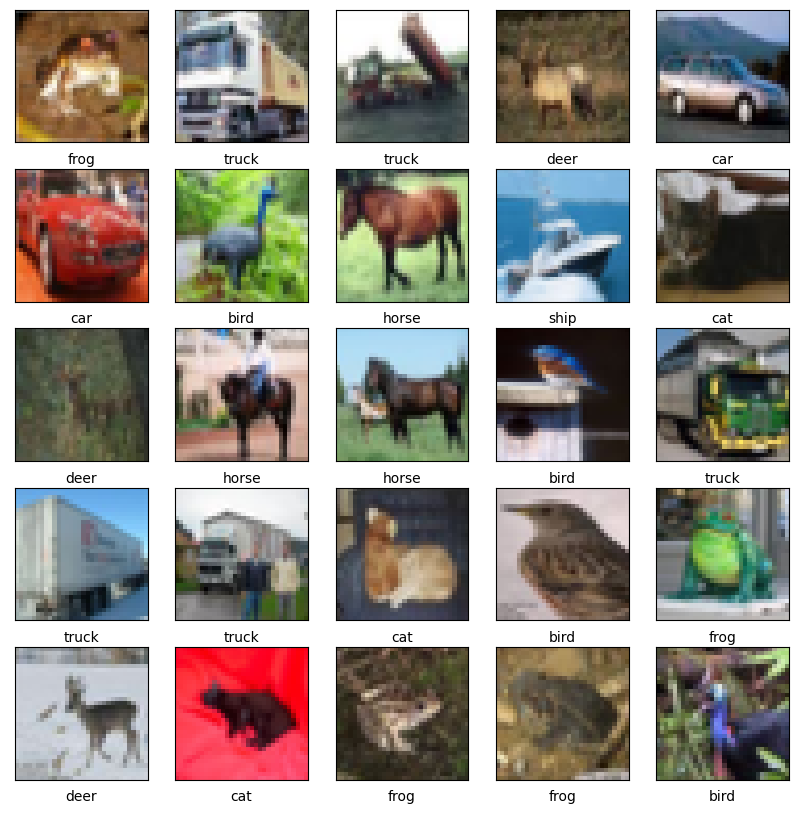

In [4]:
class_names = ['plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [5]:
model = DenseNet(input_shape=(32, 32, 3), nb_blocks=2, filters=growth_k, training=True).model

In [6]:
learning_rate = 0.001
epochs = 30

optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate,
)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(
    train_images, 
    train_labels, 
    epochs=epochs, 
    validation_data=(test_images, test_labels),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

Epoch 1/30


2024-11-28 20:36:53.823662: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


   6/1563 [..............................] - ETA: 3:54 - loss: 2.3714 - accuracy: 0.1927

KeyboardInterrupt: 